Price Prediction With Regression Analysis in R

In [1]:
install.packages("corrplot")
install.packages("glmnet")
install.packages("ggplot2")



The downloaded binary packages are in
	/var/folders/11/mktbwy31519g01sbl5b6y3_c0000gn/T//RtmpfXoiqS/downloaded_packages

The downloaded binary packages are in
	/var/folders/11/mktbwy31519g01sbl5b6y3_c0000gn/T//RtmpfXoiqS/downloaded_packages

The downloaded binary packages are in
	/var/folders/11/mktbwy31519g01sbl5b6y3_c0000gn/T//RtmpfXoiqS/downloaded_packages


In [2]:
library(ggplot2)
library(corrplot)
library(glmnet)


corrplot 0.92 loaded

Loading required package: Matrix

Loaded glmnet 4.1-8



Task 2: Load the Dataset

In [3]:
# Load the dataset as a data frame
dataset <- read.csv("bitcoin_price_data.csv")
# View the data frame
print(head(dataset))

                timestamp    price      ma5 ma10 macd signalLine rsi
1 2023-06-25 18:00:30.293 30469.36     0.00    0    0          0   0
2 2023-06-25 22:00:21.902 30236.23     0.00    0    0          0   0
3 2023-06-26 02:00:54.258 30401.99     0.00    0    0          0   0
4 2023-06-26 06:00:40.556 30323.57     0.00    0    0          0   0
5 2023-06-26 10:00:12.684 30443.05 30374.84    0    0          0   0
6   2023-06-26 14:00:17.1 30259.43 30332.85    0    0          0   0


Task 3: Explore the Dataset

In [4]:
#Find the dimension of the data frame
dim(dataset)
#Displays internal structure of data frame
str(dataset)

[1] 540   7

'data.frame':	540 obs. of  7 variables:
 $ timestamp : chr  "2023-06-25 18:00:30.293" "2023-06-25 22:00:21.902" "2023-06-26 02:00:54.258" "2023-06-26 06:00:40.556" ...
 $ price     : num  30469 30236 30402 30324 30443 ...
 $ ma5       : num  0 0 0 0 30375 ...
 $ ma10      : num  0 0 0 0 0 ...
 $ macd      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ signalLine: num  0 0 0 0 0 0 0 0 0 0 ...
 $ rsi       : num  0 0 0 0 0 0 0 0 0 0 ...


In [5]:
#Get a list of unique elements in each column
ulist <- lapply(dataset, unique)
ulen <- lengths(ulist)
#Print the number of unique values in each column
print(ulen)

 timestamp      price        ma5       ma10       macd signalLine        rsi 
       540        540        537        532        516        508        527 


Task 4: Preprocess the Dataset

In [6]:
# Print the head of the original data frame
print(head(dataset))


                timestamp    price      ma5 ma10 macd signalLine rsi
1 2023-06-25 18:00:30.293 30469.36     0.00    0    0          0   0
2 2023-06-25 22:00:21.902 30236.23     0.00    0    0          0   0
3 2023-06-26 02:00:54.258 30401.99     0.00    0    0          0   0
4 2023-06-26 06:00:40.556 30323.57     0.00    0    0          0   0
5 2023-06-26 10:00:12.684 30443.05 30374.84    0    0          0   0
6   2023-06-26 14:00:17.1 30259.43 30332.85    0    0          0   0


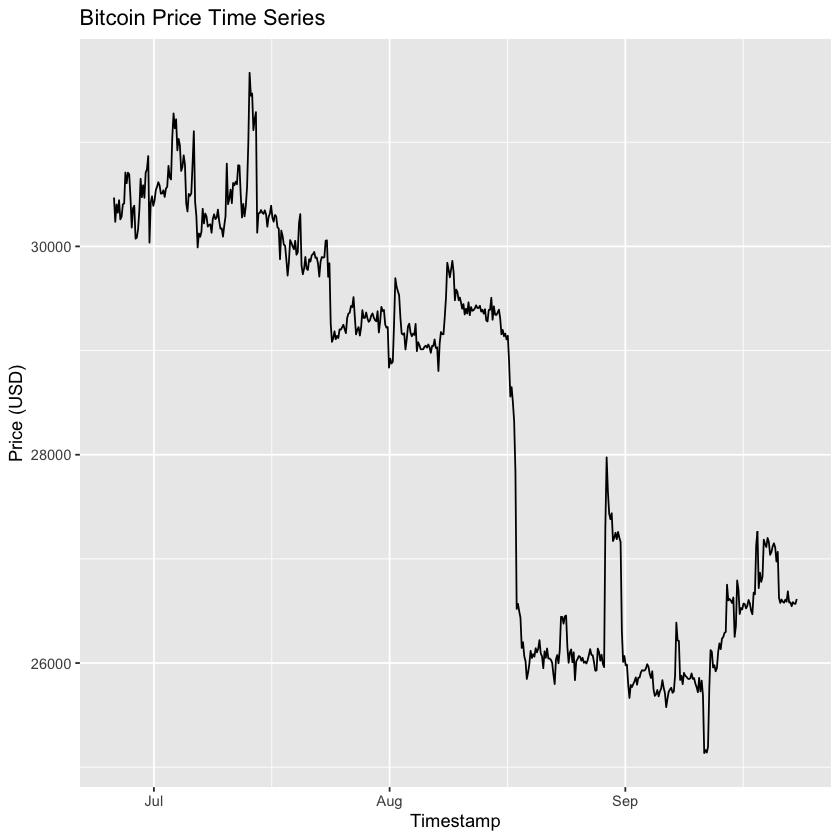

In [7]:
# Convert the timestamp column to a date-time object
dataset$timestamp <- as.POSIXct(dataset$timestamp)

# Plot the price data
ggplot(dataset, aes(x = timestamp, y = price)) +
  geom_line() +
  labs(title = "Bitcoin Price Time Series", x = "Timestamp", y = "Price (USD)")


In [9]:
str(dataset)


'data.frame':	540 obs. of  7 variables:
 $ timestamp : POSIXct, format: "2023-06-25 18:00:30" "2023-06-25 22:00:21" ...
 $ price     : num  30469 30236 30402 30324 30443 ...
 $ ma5       : num  0 0 0 0 30375 ...
 $ ma10      : num  0 0 0 0 0 ...
 $ macd      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ signalLine: num  0 0 0 0 0 0 0 0 0 0 ...
 $ rsi       : num  0 0 0 0 0 0 0 0 0 0 ...


In [10]:
# Select only numeric columns for scaling
numeric_data <- dataset[, sapply(dataset, is.numeric)]

# Scale data
scaled_data <- scale(numeric_data)

# Convert to data frame
scaled_dataset <- as.data.frame(scaled_data)

# Add the timestamp column back to the scaled data frame
scaled_dataset$timestamp <- dataset$timestamp

# Reorder the columns to place timestamp at the beginning (optional)
scaled_dataset <- scaled_dataset[c("timestamp", names(scaled_dataset)[names(scaled_dataset) != "timestamp"])]

# Display the initial rows of the scaled data frame
print(head(scaled_dataset))


            timestamp    price        ma5      ma10      macd signalLine
1 2023-06-25 18:00:30 1.124332 -9.1959182 -6.846341 0.2606713  0.2802653
2 2023-06-25 22:00:21 0.999749 -9.1959182 -6.846341 0.2606713  0.2802653
3 2023-06-26 02:00:54 1.088330 -9.1959182 -6.846341 0.2606713  0.2802653
4 2023-06-26 06:00:40 1.046420 -9.1959182 -6.846341 0.2606713  0.2802653
5 2023-06-26 10:00:12 1.110273  0.7252198 -6.846341 0.2606713  0.2802653
6 2023-06-26 14:00:17 1.012144  0.7115061 -6.846341 0.2606713  0.2802653
        rsi
1 -3.429078
2 -3.429078
3 -3.429078
4 -3.429078
5 -3.429078
6 -3.429078


Task 5: Find Outliers in the Dataset

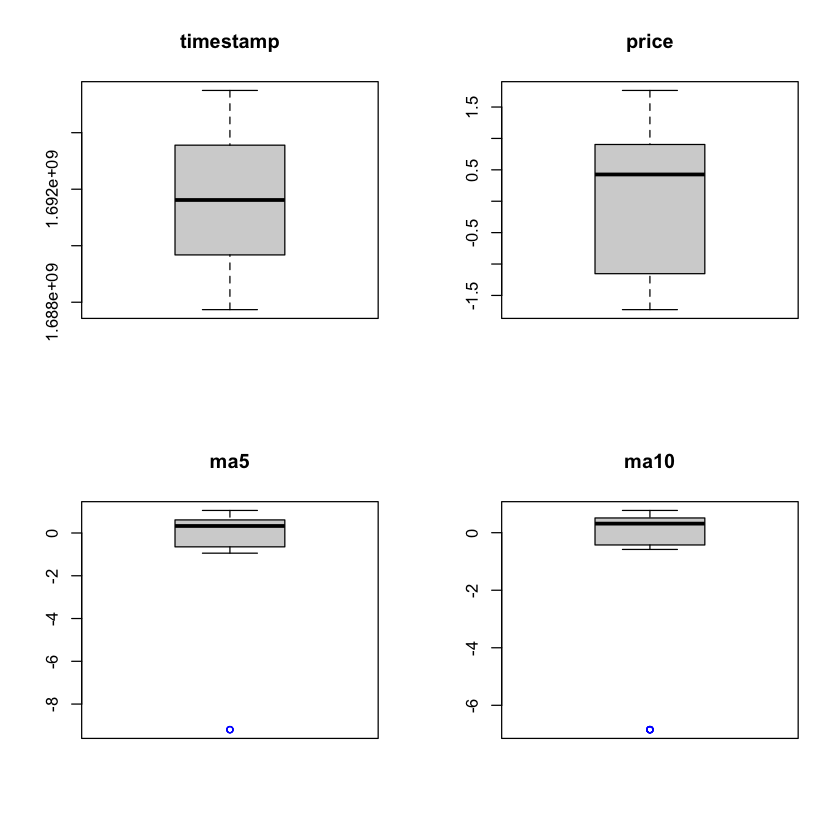

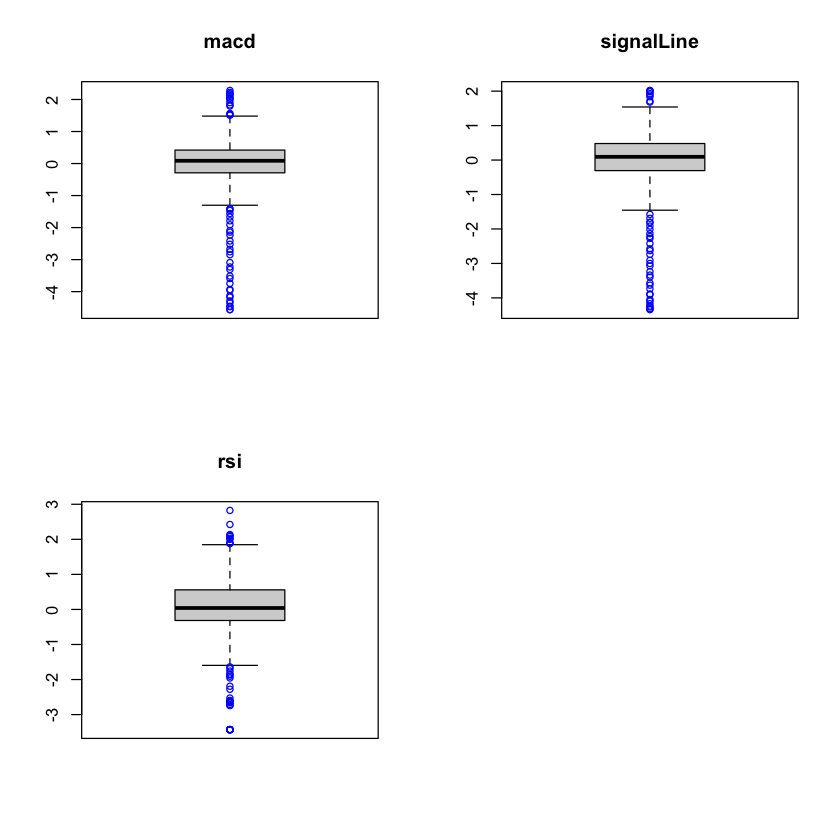

In [12]:
# Create a grid of boxplots
par(mfrow=c(2,2))
for (i in 1:ncol(scaled_dataset)) {
    boxplot(scaled_dataset[,i], main=names(scaled_dataset)[i], type="l", outcol="blue")
}


Task 6: Feature Correlation Visualisation

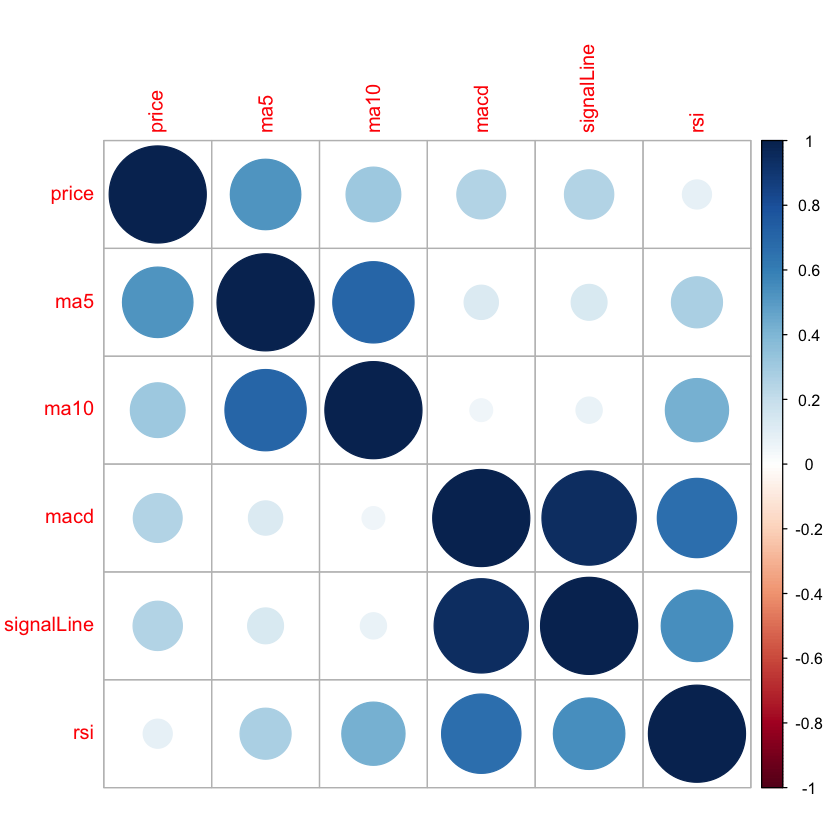

In [14]:
# Calculate correlation
scaled_dataset_cor <- cor(scaled_dataset[, sapply(scaled_dataset, is.numeric)])

# Load the corrplot package
if (!requireNamespace("corrplot", quietly = TRUE)) {
  install.packages("corrplot")
}
library(corrplot)

# Display the correlation plot
corrplot(scaled_dataset_cor)


Linear Regression

Task 7: Split Test and Train Data

In [19]:
## Make the results reproducible
set.seed(1)

# Use 70% of the dataset as a training set and 30% as a test set
sample <- sample(seq(1, 2), nrow(scaled_dataset), replace=TRUE, prob=c(0.7, 0.3))
train_set <- scaled_dataset[sample == 1, ]
test_set <- scaled_dataset[sample == 2, ]


In [28]:
# Store the target variable and other variables of the complete dataset separately
x_vars_df <- scaled_dataset[, -2]
y_var_df <- scaled_dataset[, 2]

# Store the target variable and other variables of the test data
test_set_x <- test_set[, -2]
test_set_y <- test_set[, 2]




In [29]:
print(nrow(train_set))
print(nrow(test_set))


[1] 382
[1] 158


Task 8: Train the Model 

In [31]:
fit_train <- lm(price ~ ma5 + ma10 + macd + signalLine + rsi, data = train_set)


In [32]:
print(names(train_set))

[1] "timestamp"  "price"      "ma5"        "ma10"       "macd"      
[6] "signalLine" "rsi"       


In [33]:
print(summary(fit_train))


Call:
lm(formula = price ~ ma5 + ma10 + macd + signalLine + rsi, data = train_set)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.6524 -0.6969  0.1491  0.5563  4.7666 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.01086    0.04073   0.267 0.789819    
ma5          0.47925    0.06045   7.928 2.56e-14 ***
ma10         0.12901    0.07111   1.814 0.070425 .  
macd         0.57304    0.17036   3.364 0.000848 ***
signalLine  -0.10464    0.14356  -0.729 0.466517    
rsi         -0.44245    0.06934  -6.381 5.19e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7933 on 376 degrees of freedom
Multiple R-squared:  0.3666,	Adjusted R-squared:  0.3581 
F-statistic: 43.52 on 5 and 376 DF,  p-value: < 2.2e-16



Task 9: Test the Model

In [34]:
fit_test = predict(fit_train, newdata=test_set_x)

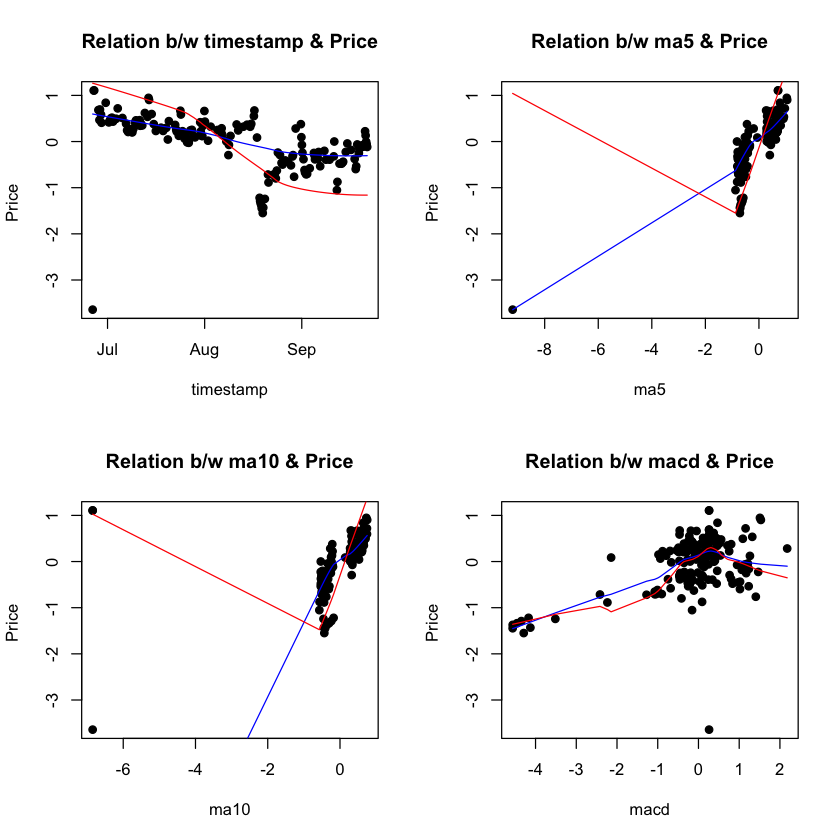

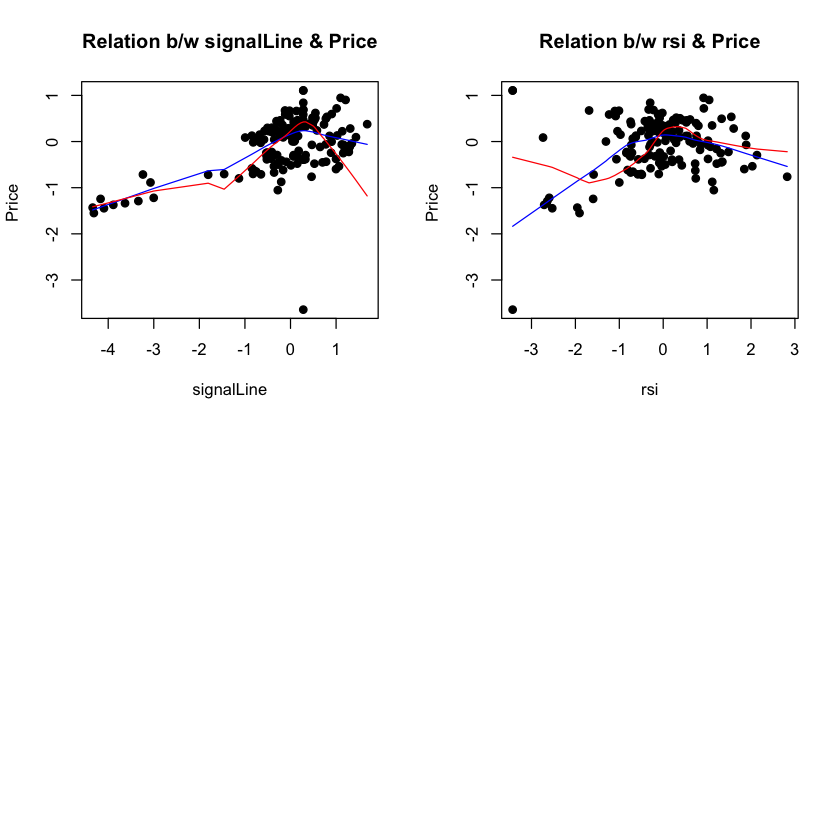

In [35]:
#Create a grid for scatter plots
par(mfrow=c(2,2))
for (i in 1:length(test_set_x)) {
     main_label=paste("Relation b/w", names(test_set_x[i]),"& Price", sep = " ", collapse = NULL)
     plot(test_set_x[,i], fit_test , main=main_label, xlab=names(test_set_x[i]), ylab="Price ",pch=19)
     lines(lowess(test_set_x[,i],fit_test), col="blue")
     lines(lowess(test_set_x[,i],test_set_y), col="red")       
}

Task 10: Evaluate the Model

In [36]:
mse <- ( mean((fit_test- (test_set_y))^2) )
print(mse)

[1] 0.6106734


In [37]:
#find SST and SSE
sst <- sum((test_set_y - mean(test_set_y))^2)
sse <- sum((fit_test - test_set_y)^2)

#find R-Squared of test Data
rsq <- 1 - sse/sst
print(rsq)

[1] 0.4120188


 Lasso Regression

Task 11: Prepare the Data 

In [43]:
# Exclude the 'timestamp' column
x_vars_df <- x_vars_df[,-1]
test_set_x <- test_set_x[,-1]
train_set <- train_set[,-1]

# Convert all data frames to matrices
x_vars <- as.matrix(x_vars_df)
y_var <- as.matrix(y_var_df)
x_test <- as.matrix(test_set_x)
y_test <- as.vector(test_set_y)
x_train <- as.matrix(train_set[, -1])
y_train <- as.vector(train_set[, 1])
train <- as.matrix(train_set)


In [44]:
#Verify the split
print(length(y_train))
print(length(y_test))

[1] 382
[1] 158


Task 12: Create and Run Lasso Regression Model

In [45]:
lambda_seq <- 10^seq(-2, 2, by = .1)

#Train the model
cv_output <- cv.glmnet(x_train, y_train, alpha = 1, lambda = lambda_seq, nfolds = 5)

Task 13: Find the Best Lambda Value

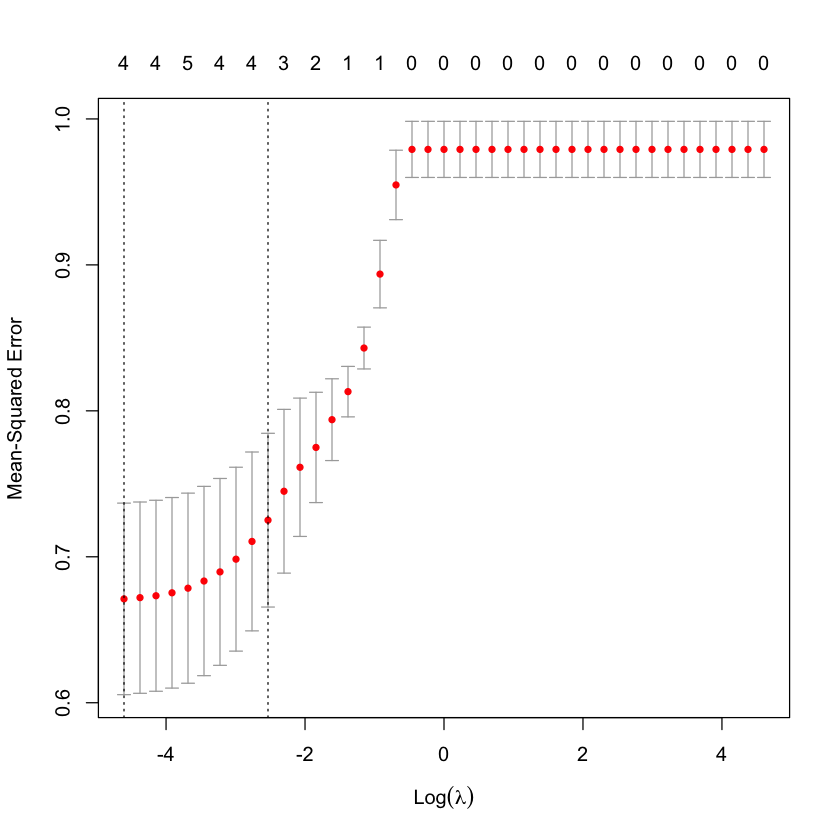

In [46]:
plot(cv_output)

In [47]:
best_lam <- cv_output$lambda.min
print(best_lam)

[1] 0.01


 Task 14: Build Lasso Model With the Best Lambda

In [48]:
#Build a Model
lasso_best <- glmnet(x_train, y_train, alpha = 1, lambda = best_lam)

#Display the coefficients of all variables after training
print(coef(lasso_best))

#Display the list of variables with zero coefficients
print("Following variables are declared irrelevant by the model:")
print(coef(lasso_best)[coef(lasso_best)[,1]==0,])

6 x 1 sparse Matrix of class "dgCMatrix"
                     s0
(Intercept)  0.01352356
ma5          0.48366663
ma10         0.08744173
macd         0.41633568
signalLine   .         
rsi         -0.37532317
[1] "Following variables are declared irrelevant by the model:"
[1] 0


Task 15: Test the Model

In [49]:
pred <- predict(lasso_best, s = best_lam, newx = x_test)

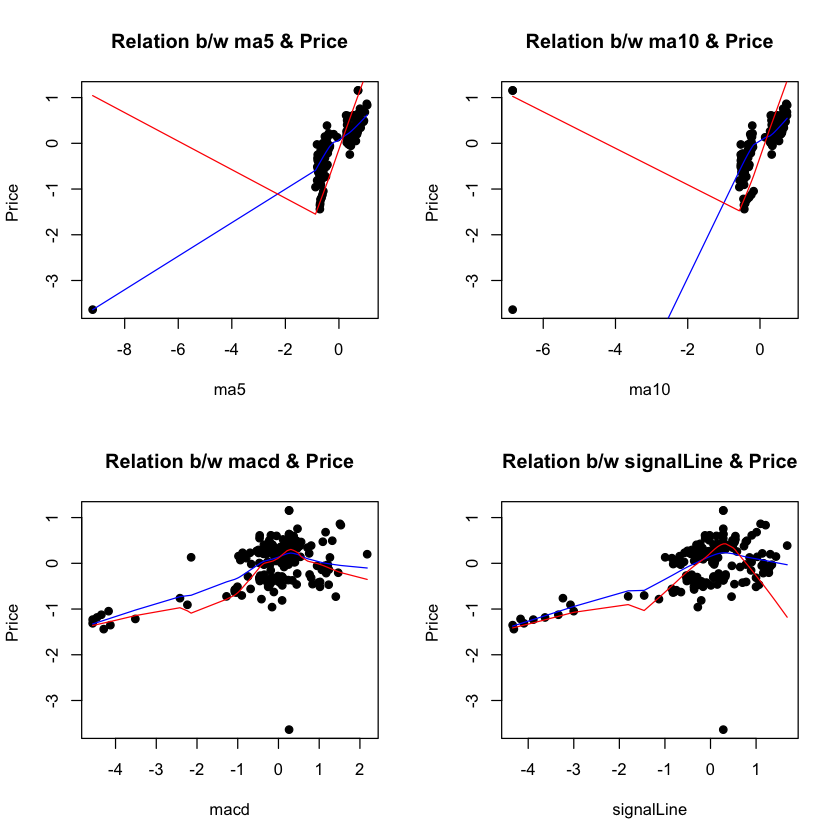

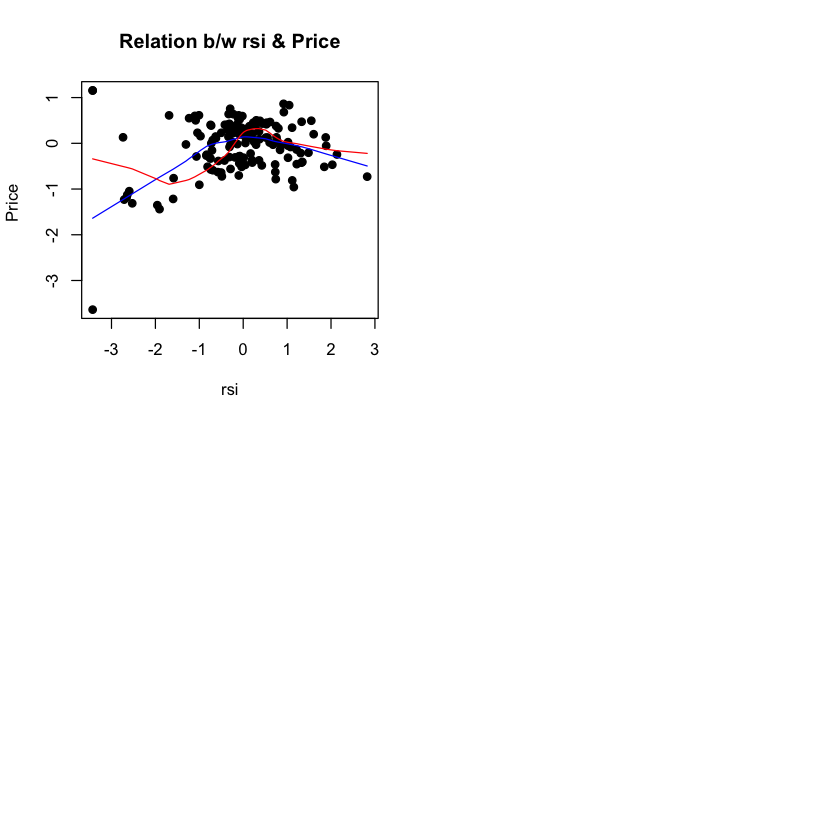

In [50]:
#Create a grid for scatter plots
par(mfrow=c(2,2))
for (i in 1:length(test_set_x)) {
     main_label=paste("Relation b/w", names(test_set_x[i]),"& Price", sep = " ", collapse = NULL)
     plot(test_set_x[,i], pred , main=main_label, xlab=names(test_set_x[i]), ylab="Price ",pch=19)
     lines(lowess(test_set_x[,i],pred), col="blue")
     lines(lowess(test_set_x[,i],y_test), col="red")       
}

Task 16: Evaluate the Model

In [51]:
#Calculate the MSE of the test data:
mse <- (mean((pred - y_test)^2)) 
print(mse)

[1] 0.6251932


In [52]:
#Find SST and SSE
sst <- sum((y_test - mean(y_test))^2)
sse <- sum((pred - y_test)^2)

#Find R-Squared of test Data
rsq <- 1 - sse/sst
print(rsq)

[1] 0.3980385
